# 약물-단백질 상호작용

## 단백질 특성 표현법
- 단백질은 여러 아미노산의 다양한 조합으로 구성된다
- 아미노산은 20개의 표준 아미노산과 이외의 희귀 아미노산으로 분류된다
- 머신러닝 모델의 입력으로 사용할 단백질 데이터는 아미노산을 알파셋으로 표현한 배열로 사용한다

In [ ]:
!pip install pandas-flavor
!pip install git+https://github.com/bp-kelley/descriptastorus
!pip install DeepPurpose


[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/bp-kelley/descriptastorus to c:\users\tonyw\appdata\local\temp\pip-req-build-mngdqb61
  Resolved https://github.com/bp-kelley/descriptastorus to commit 86eedc60546abe6f59cdbcb12025a61157ba178d
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/bp-kelley/descriptastorus 'C:\Users\tonyw\AppData\Local\Temp\pip-req-build-mngdqb61'

[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 약물-단백질 상호작용(DTI) 이해

- 약물과 단백질의 상호작용 정도를 점수화한 데이터를 통해 학습하는 머신러닝 모델
- 약물과 단백질 데이터를 동시에 입력받아 상호작용 점수를 예측한다
- 동작은 아래와 같음
    1. 약물의 특성과 단백질(타겟)의 특성을 추출한다 (모델은 MLP, CNN, LSTM, Transformer 등 다양한 모델 사용가능)
    2. 추출된 특성을 이어붙여(concatenate) 예측 레이어에 입력한다
    3. 예측레이어를 통해 최종 상호작용 점수를 예측한다 (상호작용 여부를 분류하는 경우 0과 1로 이진분류, 상호작용 점수를 예측하는 경우 회귀)
![nn](image/DTI.png)

### DeepPurpose 모듈 소개
- 약물-단백질 상호작용 예측 모델은 간단히 구현할 수 있도록 다양한 기능을 제공하는 모듈

In [1]:
import torch
import DeepPurpose.DTI as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *
import numpy as np

In [4]:
X_drug, X_target, y = load_process_DAVIS('./data/', binary=True)

drug_encoding = 'Morgan'
target_encoding = 'AAC'
train, val, test = data_process(X_drug, X_target, y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[0.8,0.1,0.1])

Beginning Processing...
100% [............................................................................] 179878 / 179878Beginning to extract zip file...
Default binary threshold for the binding affinity scores are 30, you can adjust it by using the "threshold" parameter
Done!
Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
splitting dataset...
Done.


In [5]:
X_target[0]

'MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL'

## 머신러닝을 이용한 DTI 예측 모델

### 데이터 확인

In [6]:
train

,SMILES,Target Sequence,Label,drug_encoding,target_encoding
0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.221, 3.33, 3.434, 4.683, 1.353, 4.475, 11.6..."
1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."
2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."
3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."
4,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."
...,...,...,...,...,...
24039,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MRSGAERRGSSAAASPGSPPPGRARPAGSDAPSALPPPAAGQPRAR...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.025, 7.819, 3.086, 6.996, 1.44, 7.202, 4.52..."
24040,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSS...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.814, 4.788, 3.499, 4.42, 1.657, 7.735, 3.49..."
24041,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.765, 4.593, 5.648, 4.367, 2.033, 9.036, 4.6..."
24042,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.5, 5.875, 4.125, 5.375, 1.375, 7.375, 4.125..."


In [7]:
num = 5
print('Drug 1: ' + X_drug[num])
print('Target 1: ' + X_target[num])
print('Score 1: ' + str(y[num]))

Drug 1: CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N
Target 1: PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLS

### 모델 정의 및 학습

In [8]:
config = generate_config(drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 20, 
                         LR = 0.001, 
                         batch_size = 256
                        )
model = models.model_initialize(**config)
# 모델 구조 파악
print(model.model)

Classifier(
  (model_drug): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (model_protein): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=8420, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)


Let's use 2 GPUs!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69588. Total time 0.00055 hours
Validation at Epoch 1, AUROC: 0.85741 , AUPRC: 0.29639 , F1: 0.15642 , Cross-entropy Loss: 1.73498
Training at Epoch 2 iteration 0 with loss 0.12716. Total time 0.00277 hours
Validation at Epoch 2, AUROC: 0.88939 , AUPRC: 0.36739 , F1: 0.17977 , Cross-entropy Loss: 1.67753
Training at Epoch 3 iteration 0 with loss 0.08862. Total time 0.00527 hours
Validation at Epoch 3, AUROC: 0.88316 , AUPRC: 0.34303 , F1: 0.13793 , Cross-entropy Loss: 1.72349
Training at Epoch 4 iteration 0 with loss 0.13322. Total time 0.0075 hours
Validation at Epoch 4, AUROC: 0.87325 , AUPRC: 0.34129 , F1: 0.08536 , Cross-entropy Loss: 1.72349
Training at Epoch 5 iteration 0 with loss 0.20466. Total time 0.00972 hours
Validation at Epoch 5, AUROC: 0.88209 , AUPRC: 0.37852 , F1: 0.18285 , Cross-entropy Loss: 1.64306
Training at Epoch 6 iteration 0 with loss 0.12509. Total ti

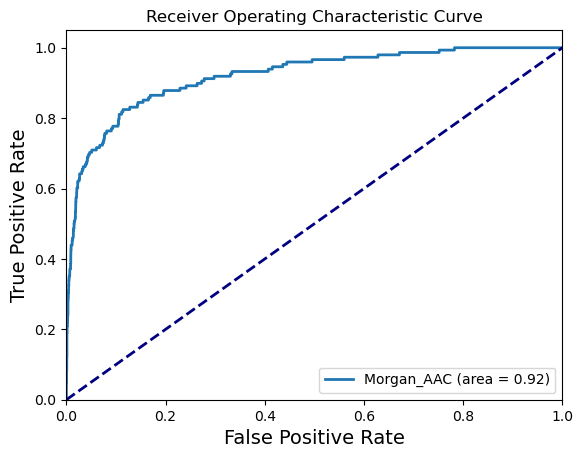

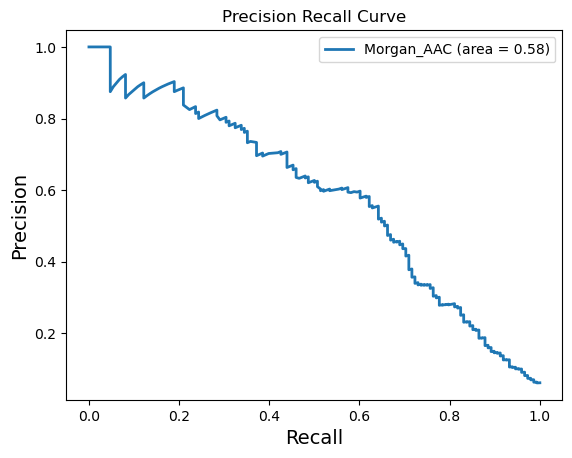

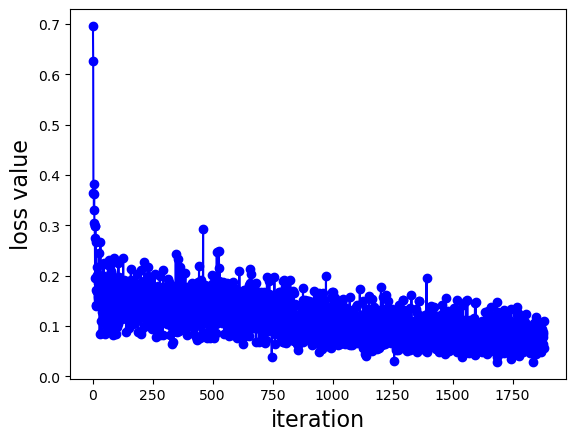

In [9]:
model.train(train, val, test)

In [10]:
drug_encoding = 'CNN'
target_encoding = 'CNN'
train, val, test = data_process(X_drug, X_target, y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[0.8,0.1,0.1])


config = generate_config(cuda_id = 0,
                         drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [512,128], 
                         train_epoch = 20, 
                         LR = 0.001, 
                         batch_size = 256,
                         cnn_drug_filters = [32,32],
                         cnn_target_filters = [32,32],
                         cnn_drug_kernels = [4,6],
                         cnn_target_kernels = [4,8]
                        )
model = models.model_initialize(**config)
# 모델 구조 파악
print(model.model)

Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
splitting dataset...
Done.
Classifier(
  (model_drug): CNN(
    (conv): ModuleList(
      (0): Conv1d(63, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 32, kernel_size=(6,), stride=(1,))
    )
    (fc1): Linear(in_features=32, out_features=256, bias=True)
  )
  (model_protein): CNN(
    (conv): ModuleList(
      (0): Conv1d(26, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 32, kernel_size=(8,), stride=(1,))
    )
    (fc1): Linear(in_features=32, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


Let's use 2 GPUs!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.70914. Total time 0.00027 hours
Validation at Epoch 1, AUROC: 0.83492 , AUPRC: 0.28627 , F1: 0.0 , Cross-entropy Loss: 1.71200
Training at Epoch 2 iteration 0 with loss 0.18843. Total time 0.01833 hours
Validation at Epoch 2, AUROC: 0.86724 , AUPRC: 0.32465 , F1: 0.07692 , Cross-entropy Loss: 1.65455
Training at Epoch 3 iteration 0 with loss 0.23862. Total time 0.03611 hours
Validation at Epoch 3, AUROC: 0.87908 , AUPRC: 0.34711 , F1: 0.14689 , Cross-entropy Loss: 1.73498
Training at Epoch 4 iteration 0 with loss 0.10307. Total time 0.05416 hours
Validation at Epoch 4, AUROC: 0.87850 , AUPRC: 0.36130 , F1: 0.08917 , Cross-entropy Loss: 1.64306
Training at Epoch 5 iteration 0 with loss 0.17137. Total time 0.07194 hours
Validation at Epoch 5, AUROC: 0.87882 , AUPRC: 0.36152 , F1: 0.17582 , Cross-entropy Loss: 1.72349
Training at Epoch 6 iteration 0 with loss 0.12308. Total time 

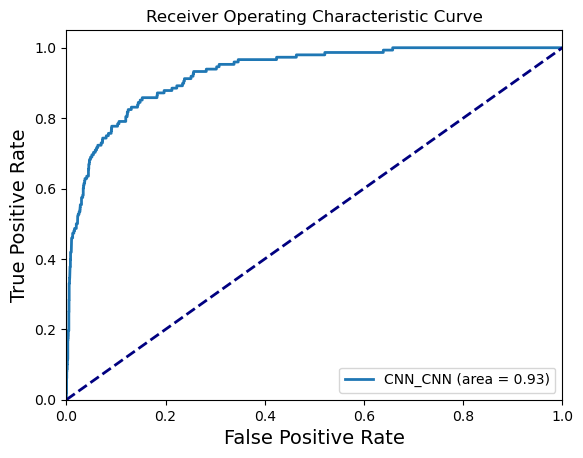

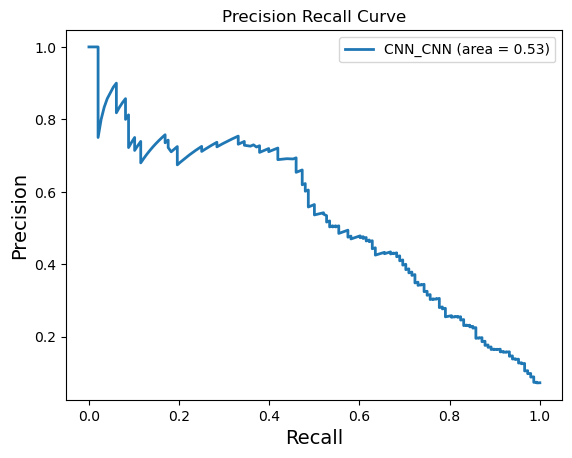

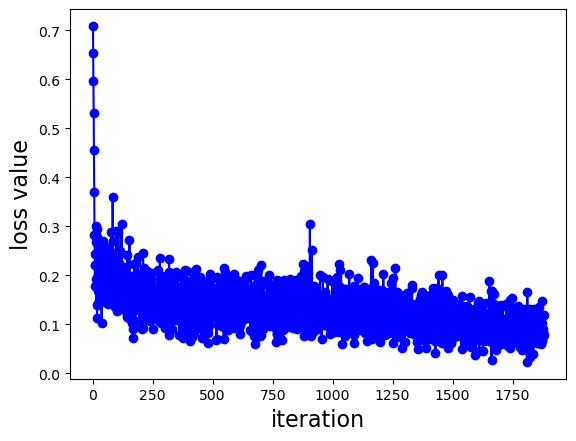

In [11]:
model.train(train, val, test)

In [17]:
def get_test_result():
    with open('./result/test_markdowntable.txt', 'r') as f:
        result = f.readlines()[-2].replace(' ', '').split('|')
        AUROC, AUPRC, F1 = result[1], result[2], result[3]
        return AUROC, AUPRC, F1

In [18]:
get_test_result()

('0.9932', '0.9876', '0.9839')

## 약물 재창출
- 기존의 FDA허가 물질의 다른 질병(단백질)에 대한 효과를 예측하는 약물 재창출 프로그래밍 방법 습득
- DeepPurpose에서 제공하는 사전 학습된 DTI모델에 다른 타겟 질병(단백질)과 기존의 약물을 입력으로 넣어 상호작용을 예측

In [40]:
target, target_name = load_SARS_CoV_Protease_3CL() # SARS-CoV : 중증급성호흡기증후군-코로나바이러스
drug, drug_names = load_antiviral_drugs('./data', no_cid = True) # 항 바이러스 약물 데이터셋
print('target_name :\t', target_name)
print('target :\t', target[:100], '...')
print('drug_names :\t', drug_names[0])
print('drug :\t\t', drug[0])

target_name :	 SARS-CoV 3CL Protease
target :	 SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKFSGDQWGDVLNLANNHEFEVVTQNGVTLNVVSRRLKGAVLILQTAVANAETPKYK ...
drug_names :	 Abacavir
drug :		 C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)C4CC(C=C4)CO


In [41]:
import DeepPurpose.oneliner as oneliner

oneliner.repurpose(*load_SARS_CoV2_Protease_3CL(), *load_antiviral_drugs(no_cid = True))

Loading customized repurposing dataset...
Beginning Downloading Pretrained Model...
Note: if you have already download the pretrained model before, please stop the program and set the input parameter 'pretrained_dir' to the path
Dataset already downloaded in the local system...
Using pretrained model and making predictions...
repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Predictions from model 1 with drug encoding MPNN and target encoding CNN are done...
-------------
repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Predictions from model 2 with drug encoding CNN and target encoding CNN are done...
-------------
repurposing...
Drug Target Interaction Prediction Mode...
in tota